# EDA for Reviews Dataset

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

## Introduction

Notebook to perform Exploratory Data Analysis and preprocessing on a reviews dataset of Amazon foods.
The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

## Data Dictionary


| Column Name            | Description                                                               | Data Type |
| ---------------------- | ------------------------------------------------------------------------- | --------- |
| Id                     | Row ID                                                                    | int64     |
| ProductId              | Unique identifier for Product                                             | object    |
| UserId                 | Unique identifier for User                                                | object    |
| ProfileName            | Profile name of the user                                                  | object    |
| HelpfulnessNumerator   | Number of users who found the review helpful                              | int64     |
| HelpfulnessDenominator | Number of users who indicated wether they found the review helpful or not | int64     |
| Score                  | Rating between 1 and 5                                                    | int64     |
| Time                   | Timestamp for the review                                                  | int64     |
| Summary                | Brief summary of the review                                               | object    |
| Text                   | Full review                                                               | object    |


# EDA

## Import Libraries and Load DataFrame

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# Read compressed csv file
df = pd.read_csv('../data/Reviews.csv.gz',compression = 'gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
df.shape

(568454, 10)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


From the cells above we see there are
- 568,454 reviews in total
- There are 10 columns
- The `Text` and `Score` columns are probably going to be the only ones we use

Just for completeness let's check if there are any null values:

In [6]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Only the `ProfileName` and `Summary` have null values. No issue because we're not really going to use these two columns as features.

In [7]:
df.duplicated().sum()

0

No duplicate rows.

## Distribution of Review Scores

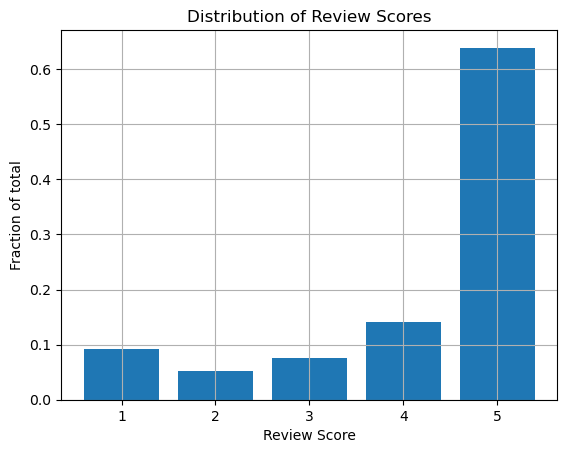

In [8]:
ind = df['Score'].value_counts(normalize = True).index
val = df['Score'].value_counts(normalize = True).values

plt.bar(ind,val)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Fraction of total')
plt.grid()

plt.savefig('review_score_dist.png')

We can see that there is a class imbalance in the review score: over 60% of the reviews are scored 5, whereas the remaining 40% all range from 1 to 4. 

Therefore, we have different approaches to try and predict the sentiment of the review:
- We can establish a threshold as to what constitutes a positive or negative review
- We can convert the problem to 3-class (negative, neutral, positive) and downsample the positive reviews
- If we want to preserve the review scores (multiclass classification) we can downsample the reviews with score 5

## Distribution of Reviews by Product ID

In [9]:
prod_val_counts = df['ProductId'].value_counts()

In [10]:
prod_val_counts

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B004DSPTTM      1
B008C9QWU8      1
B007O5A6BM      1
B003Q4TZ08      1
B001LR2CU2      1
Name: count, Length: 74258, dtype: int64

In [11]:
df.shape

(568454, 10)

We can see that there are 74,258 unique products and they all have anywhere between 1 and 913 different reviews. We could perhaps remove the products that have less than 5 reviews.

In [12]:
ind = (prod_val_counts.values > 5)
prod_val_counts[ind]

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B000F764BW      6
B003DNL9VA      6
B004FH6NHS      6
B000FVZW70      6
B001EO7F8G      6
Name: count, Length: 17310, dtype: int64

Text(0, 0.5, 'Frequency')

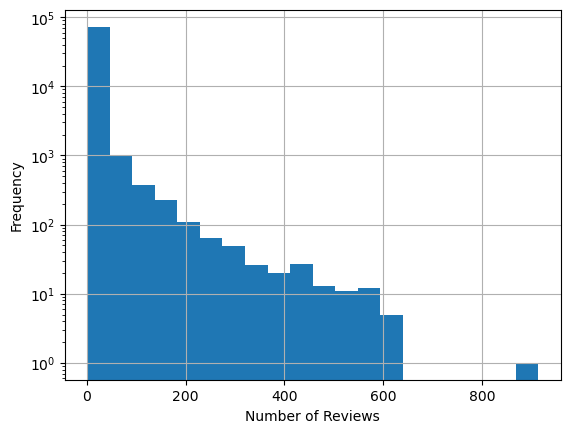

In [13]:
plt.hist(prod_val_counts.values,20)
plt.yscale('log')
plt.grid()
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

From the graph above we see that products with less than 200 reviews have a higher frequency.

There is also a gap in number of reviews between ~650 and 850. From the value counts before we see that there is one product which has 913 reviews, and the next set of products have 632.

## Average Length of Review

We'll now calculate for each score what is the average length of a review.

In [17]:
df[['Score','Text']].head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [26]:
df['review_n_char'] = df['Text'].apply(lambda x: len(x))

In [27]:
df[['Score','review_n_char']]

,Score,review_n_char
0,5,263
1,1,190
2,4,509
3,2,219
4,5,140
...,...,...
568449,5,149
568450,2,252
568451,5,372
568452,5,200


In [30]:
agg_df = df[['Score','review_n_char']].groupby('Score').aggregate('mean')

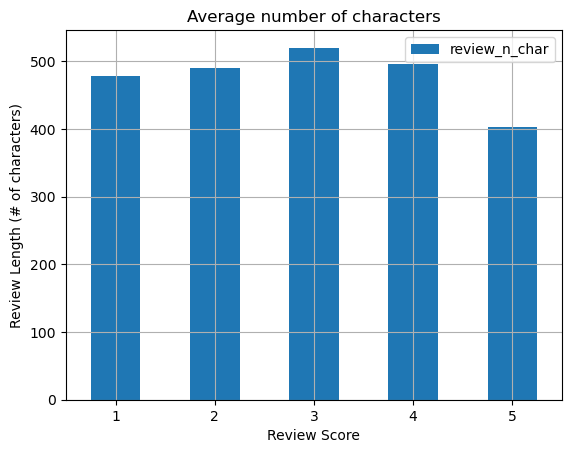

In [37]:
agg_df.plot(kind = 'bar')
plt.title('Average number of characters')
plt.xlabel('Review Score')
plt.ylabel('Review Length (# of characters)')
plt.grid()
ticks = plt.xticks(rotation = 0)

From the graph above we see that, on average, there is no significant difference in the average number of characters of each review. 

The reviews with the highest score (5) seem to have the least number of characters.

## EDA Findings

- Reviews on average have the same character length across all scores.
- The number of reviews per product range from 1 to 913.
- There is an class imbalance in the review score (over 60% of reviews are scored 5).

# Preprocessing

In this section I'll test the helper functions to perform preprocessing of the data set. This step will perform the following operations on the dataset:

1. Extract the relevant columns: `Text` and `Score`.
2. Map the `Score` column from [1,5] to [0,2] (negative, neutral and positive).
3. Balance the number of reviews based on the review score with least records. This will create a balanced dataset.
4. Return the balanced dataset as a pandas DataFrame.

In [65]:
import pandas as pd

def preprocess_dataset(csv_filename,rebalance=True):

    # This will convert the original scores as follows
    # 1,2 -> 0 (negative review)
    # 3 -> 1 (neutral review)
    # 4,5 -> (positive review)
    mapping = {
        1:0,2:0,3:1,4:2,5:2
        }

    df = pd.read_csv(csv_filename,compression='gzip')
    
    df_new = df[['Text','Score']].copy()
    df_new['Score'] = df_new['Score'].map(mapping).values

    if rebalance:
        score_count = df_new['Score'].value_counts()
        num_records = min(score_count.values)

        newdf = pd.DataFrame()

        for k in range(3):
            
            # sample `num_records` with given score
            tempdf = df_new.query(f'Score == {k}').sample(n = num_records, random_state = 10).copy()
    
            newdf = pd.concat([newdf,tempdf],axis = 0)

        df_new = newdf

        # here we need to add a filter so that we can return 
        # two dataframes: the balanced one, and the remaining df with the 'excluded' reviews
    

    return df_new

In [52]:
df_new = preprocess_dataset('../data/Reviews.csv.gz')

In [53]:
df_new.shape

(127920, 2)

In [54]:
df_new.columns

Index(['Text', 'Score'], dtype='object')

In [55]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127920 entries, 368500 to 40237
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    127920 non-null  object
 1   Score   127920 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [56]:
df_new['Score'].value_counts()

Score
0    42640
1    42640
2    42640
Name: count, dtype: int64

We see that now the dataset is balanced, all three Score values have the same number of reviews.

We'll have to add an additional filter to return two dataframes: the balanced one (same as above) and another with the reviews that were not used for balancing.